# 1) MiniResNet en PyTorch sobre MNIST (Visto en el cuadernillo "Diseño de CNNs – INF395")
Implementación equivalente:

In [3]:
# 1) Imports y device
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


In [4]:
# 2) Carga y split MNIST (50k train / 10k val / 10k test)
transform = transforms.ToTensor()
full_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_dataset, val_dataset = random_split(full_train, [50000, 10000], generator=torch.Generator().manual_seed(42))
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print('Train:', len(train_dataset), 'Val:', len(val_dataset), 'Test:', len(test_dataset))

100%|██████████| 9.91M/9.91M [00:00<00:00, 33.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.09MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.77MB/s]

Train: 50000 Val: 10000 Test: 10000


In [5]:
# 3) ResidualBlock
class ResidualBlock(nn.Module):
    def __init__(self, n_filters):
        super().__init__()
        self.conv1 = nn.Conv2d(n_filters, n_filters, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_filters, n_filters, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        out = out + x
        out = self.relu(out)
        return out

In [6]:
# 4) MiniResNet
class MiniResNet(nn.Module):
    def __init__(self, n_filters=32):
        super().__init__()
        self.conv = nn.Conv2d(1, n_filters, kernel_size=5, padding=2)
        self.block = ResidualBlock(n_filters)
        self.classifier = nn.Linear(28 * 28 * n_filters, 10)
    def forward(self, x):
        x = self.conv(x)
        x = self.block(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [7]:
# 5) Instanciación y configuración
model = MiniResNet(32).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
num_epochs = 5
print('Params:', sum(p.numel() for p in model.parameters() if p.requires_grad))

Params: 270218


In [8]:
# 6) Entrenamiento con validación
train_losses, val_losses = [], []
train_accs, val_accs = [], []
for epoch in range(num_epochs):
    model.train()
    run_loss = 0.0; correct = 0; total = 0
    for images, labels in train_loader:
        images = images.to(device); labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        run_loss += loss.item() * images.size(0)
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    train_loss = run_loss / total
    train_acc = correct / total
    train_losses.append(train_loss); train_accs.append(train_acc)
    model.eval()
    val_loss_accum = 0.0; val_correct = 0; val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device); labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss_accum += loss.item() * images.size(0)
            preds = outputs.argmax(1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    val_loss = val_loss_accum / val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss); val_accs.append(val_acc)
    print(f'Epoch {epoch+1}/{num_epochs} - train_loss {train_loss:.4f} train_acc {train_acc:.4f} val_loss {val_loss:.4f} val_acc {val_acc:.4f}')

Epoch 1/5 - train_loss 0.3315 train_acc 0.9036 val_loss 0.1458 val_acc 0.9546
Epoch 2/5 - train_loss 0.1023 train_acc 0.9699 val_loss 0.0997 val_acc 0.9694
Epoch 3/5 - train_loss 0.0743 train_acc 0.9779 val_loss 0.1396 val_acc 0.9575
Epoch 4/5 - train_loss 0.0608 train_acc 0.9818 val_loss 0.1309 val_acc 0.9590
Epoch 5/5 - train_loss 0.0508 train_acc 0.9847 val_loss 0.1857 val_acc 0.9434


In [9]:
# 7) Evaluación en test
model.eval()
test_loss_accum = 0.0; test_correct = 0; test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device); labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss_accum += loss.item() * images.size(0)
        preds = outputs.argmax(1)
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)
test_loss = test_loss_accum / test_total
test_acc = test_correct / test_total
print(f'Test loss {test_loss:.4f}  Test acc {test_acc:.4f}')

Test loss 0.1633  Test acc 0.9458


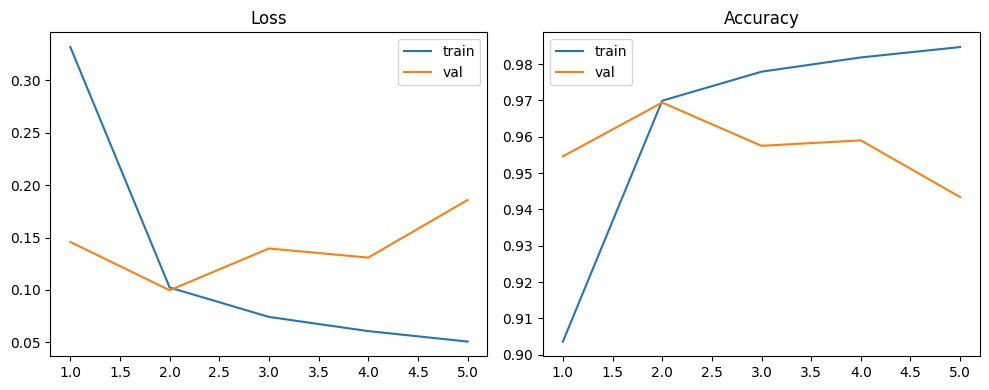

In [10]:
# 8) Gráficas
import matplotlib.pyplot as plt
epochs = range(1, num_epochs+1)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(epochs, train_losses, label='train'); plt.plot(epochs, val_losses, label='val'); plt.title('Loss'); plt.legend()
plt.subplot(1,2,2); plt.plot(epochs, train_accs, label='train'); plt.plot(epochs, val_accs, label='val'); plt.title('Accuracy'); plt.legend()
plt.tight_layout(); plt.show()

| **Componente**                 | **Versión PPT (Keras)**                                     | **Tu implementación (PyTorch)**                               | **Equivalencia / Comentario**                                                                                     |
| ------------------------------ | ----------------------------------------------------------- | ------------------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------- |
| **Capa inicial (Conv)**        | `Conv2D(n_filters, kernel_size=(5,5), padding="same")`      | `nn.Conv2d(1, n_filters, kernel_size=5, padding=2)`           | Misma operación: conv 5×5 con padding para mantener tamaño. En PyTorch el padding=2 logra “same padding”.         |
| **Bloque residual – conv1**    | `Conv2D(n_filters, 3×3, activation='relu', padding='same')` | `nn.Conv2d(n_filters, n_filters, 3, padding=1)` + `nn.ReLU()` | Misma idea: primera conv 3×3 + ReLU. En Keras el activation va dentro; en PyTorch se separa.                      |
| **Bloque residual – conv2**    | `Conv2D(n_filters, 3×3, padding='same')`                    | `nn.Conv2d(n_filters, n_filters, 3, padding=1)`               | Igual: segunda conv lineal (sin activación).                     |
| **Suma residual**              | `Add()([x, inputs])`                                        | `out = out + x`                                               | Totalmente equivalente. PyTorch usa suma directa.                                                                 |
| **ReLU final en bloque**       | `Activation('relu')`                                        | `nn.ReLU()`                                                   | Misma activación. En PyTorch se instancia como capa separada.                                                     |
| **Flatten**                    | `Flatten()`                                                 | `x.view(x.size(0), -1)`                                       | Mismo efecto: aplastar a vector 1D.                                                                               |
| **Capa final (clasificación)** | `Dense(10, activation='softmax')`                           | `nn.Linear(..., 10)` + `CrossEntropyLoss()`                   | En PyTorch NO se incluye softmax en el modelo porque `CrossEntropyLoss` ya lo incorpora. Funcionalmente idéntico. |
| **Dataset**                    | MNIST cargado con `mnist.load_data()`                       | MNIST via `torchvision.datasets.MNIST` + `ToTensor()`         | Ambas transforman la imagen a 28×28 escala de grises normalizada a [0,1].                                         |
| **Split train/val**            | 50k train / 10k val                                         | `random_split` en PyTorch (50000 y 10000)                     | Igual división.                                                                 |
| **Batch size**                 | `batch_size = 256`                                          | `batch_size = 256`                                            | Exactamente igual.                                                                                                |
| **Optimizador**                | `SGD(lr=0.1)`                                               | `torch.optim.SGD(lr=0.1)`                                     | Misma configuración.                                                                                              |
| **Loss**                       | `sparse_categorical_crossentropy`                           | `nn.CrossEntropyLoss()`                                       | Ambas trabajan con etiquetas enteras (0–9).                                                                       |
| **Epochs**                     | 5                                                           | 5                                                             | Misma configuración.                                                                                              |
